In [1]:
%matplotlib inline
#%pylab
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import matplotlib.dates as dts
import numpy as np
import pandas as pd
import itertools
import os
import ROOT
import datetime
from root_numpy import root2array, root2rec, tree2rec, array2root
from scipy.optimize import curve_fit
from scipy.misc import factorial
plt.rcParams.update({'font.size': 16})

Welcome to JupyROOT 6.10/04


In [2]:
#f = ROOT.TFile('mcc83_cosmic.root')
f = ROOT.TFile('/home/david/data/StopMuCalibration/stm_ana.root')
f.cd('stopmu')
print f
df = pd.DataFrame(tree2rec(f.Get('stopmu/reco_tree')))
print df.shape
df = df.query('_trk_start_z > 500. and _trk_end_z > 500.')
print df.shape

<ROOT.TFile object ("/home/david/data/StopMuCalibration/stm_ana.root") at 0x55a6cbe406e0>
(3888, 21)


/home/david/.local/lib/python2.7/site-packages/root_numpy/_tree.py:471: DeprecationWarning: tree2rec is deprecated and will be removed in 5.0.0. Instead use tree2array(...).view(np.recarray)
  DeprecationWarning)


(2258, 21)


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


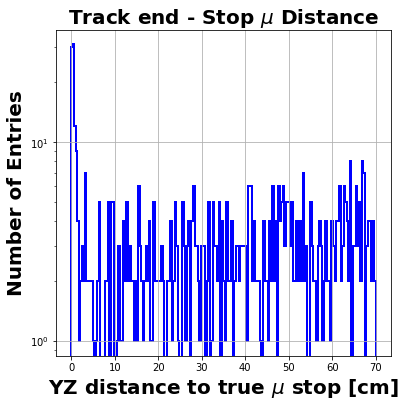

In [3]:
fig = plt.figure(figsize=(6,6))
BINS = np.linspace(0,70,201)
plt.hist(df['_yz_true_reco_distance'].values,bins=BINS,histtype='step',color='b',lw=2)
plt.grid()
plt.yscale('log')
plt.title('Track end - Stop $\mu$ Distance',fontsize=20,fontweight='bold')
plt.xlabel('YZ distance to true $\mu$ stop [cm]',fontsize=20,fontweight='bold')
plt.ylabel('Number of Entries',fontsize=20,fontweight='bold')
#plt.ylim([20,4000])
plt.show()

In [4]:
def GetMIPFit(x):
    
    dqdx_v = x['_dqdx_tm_y']
    rr_v   = x['_rr_y']
    
    rr_max = x['_trk_len']
    
    if (rr_max < 150.): return -1,-1
    
    rr_MIP_idx_v = np.where((rr_v > 100) & (rr_v < 150))[0]
    if (len(rr_MIP_idx_v) == 0): return -1,-1
    dqdx_MIP_v = [dqdx_v[i] for i in rr_MIP_idx_v]
    avg = np.average(dqdx_MIP_v)
    rms = np.std(dqdx_MIP_v)
    return avg,rms

def BraggArea(x,rmin,rmax):

    dqdx_v = x['_dqdx_tm_y']
    rr_v   = x['_rr_y']
    mip    = x['mip']
    
        
    if (mip < 0): return -1
    
    rr_BRAGG_idx_v = np.where((rr_v < rmax) & (rr_v > rmin))[0]
    area = 0
    for i in rr_BRAGG_idx_v:
        if (i < len(rr_v)-1):
            ampl = (dqdx_v[i]-mip)
            area += ampl * np.abs(rr_v[i]-rr_v[i+1])
            #print '+= ampl = %.02f \t\t dr = %.02f'%(ampl,np.abs(rr_v[i]-rr_v[i+1]))
    return area/mip

def dQfit(x,a,b,c):
    return a*x**2 + b*x + c

def MIPfit(x):
    
    dqdx_v = x['_dqdx_tm_y']
    rr_v   = x['_rr_y']
    mip    = x['mip']
    
    dqdx_v = dqdx_v.astype(float)
    rr_v   = rr_v.astype(float)
    
    if (len(rr_v) < 50):
        return -1
    
    rr_v_fit = []
    dqdx_trunc_v_fit = []
    for i,r in enumerate(rr_v):
        if (r < 50):
            rr_v_fit.append(r)
            dqdx_trunc_v_fit.append(dqdx_v[i]/mip)
    
    try:
        popt,popv = curve_fit(dQfit,rr_v_fit,dqdx_trunc_v_fit)
        return popt[2]
    except:
        return -1

In [5]:
df['mip']    = df.apply(lambda x : GetMIPFit(x)[0], axis=1)
df['miperr'] = df.apply(lambda x : GetMIPFit(x)[1], axis=1)

In [6]:
df['mipfit'] = df.apply(lambda x : MIPfit(x), axis=1)

/usr/lib/python2.7/dist-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [7]:
df['BA_000_050'] = df.apply(lambda x : BraggArea(x,0,50), axis=1)
df['BA_050_100'] = df.apply(lambda x : BraggArea(x,50,100), axis=1)

In [8]:
df = df.query('BA_000_050 != -1 and BA_050_100 != -1')

In [9]:
dfstop = df.query('_yz_true_reco_distance < 3') # cut that defines what is a true stopping muon

/home/david/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


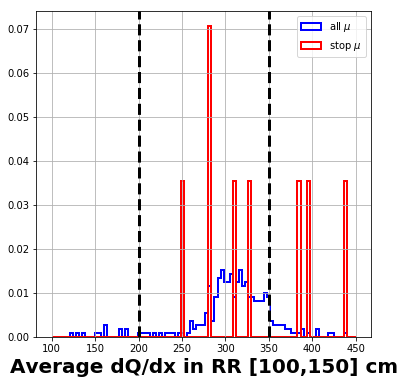

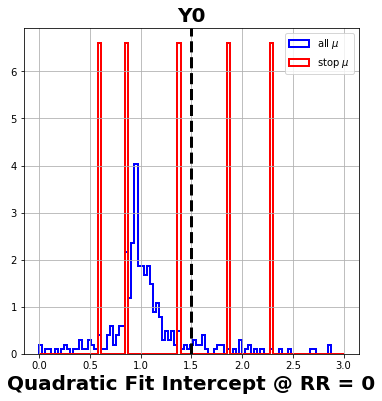

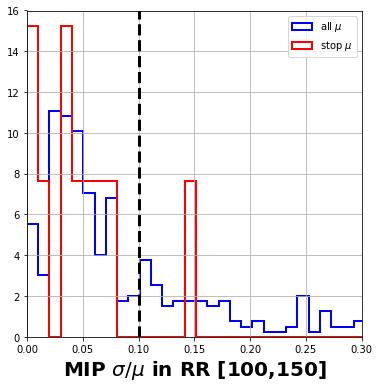

In [10]:
fig = plt.figure(figsize=(6,6))
plt.hist(df['mip'].values    ,bins=np.linspace(100,450,100),\
         histtype='step',lw=2,color='b',normed=True,label='all $\mu$')
plt.hist(dfstop['mip'].values,bins=np.linspace(100,450,100),\
         histtype='step',lw=2,color='r',normed=True,label='stop $\mu$')
plt.xlabel('Average dQ/dx in RR [100,150] cm',fontsize=20,fontweight='bold')
plt.axvline(200,color='k',linestyle='--',lw=3)
plt.axvline(350,color='k',linestyle='--',lw=3)
plt.grid()
plt.legend(loc=1)
plt.show()

fig = plt.figure(figsize=(6,6))
plt.hist(df['mipfit'].values    ,bins=np.linspace(0,3,100),\
         histtype='step',lw=2,color='b',normed=True,label='all $\mu$')
plt.hist(dfstop['mipfit'].values,bins=np.linspace(0,3,100),\
         histtype='step',lw=2,color='r',normed=True,label='stop $\mu$')
plt.xlabel('Quadratic Fit Intercept @ RR = 0',fontsize=20,fontweight='bold')
plt.title('Y0',fontsize=20,fontweight='bold')
plt.axvline(1.5,color='k',linestyle='--',lw=3)
plt.grid()
plt.legend(loc=1)
plt.show()

mipeA = df['miperr'].values / df['mip'].values
mipeS = dfstop['miperr'].values / dfstop['mip'].values

fig = plt.figure(figsize=(6,6))
plt.hist(mipeA ,bins=np.linspace(0,1,100),\
         histtype='step',lw=2,color='b',normed=True,label='all $\mu$')
plt.hist(mipeS,bins=np.linspace(0,1,100),\
         histtype='step',lw=2,color='r',normed=True,label='stop $\mu$')
plt.xlabel('MIP $\sigma/\mu$ in RR [100,150]',fontsize=20,fontweight='bold')

plt.axvline(0.1,color='k',linestyle='--',lw=3)
plt.xlim([0,0.3])
plt.grid()
plt.legend(loc=1)
plt.show()

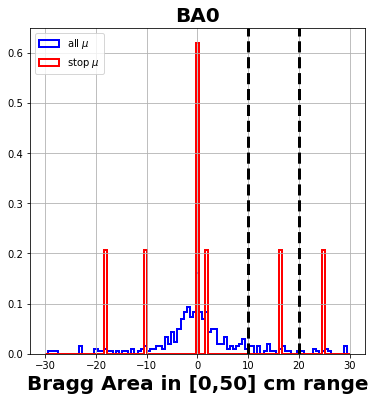

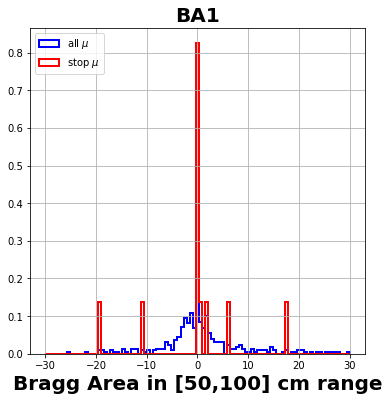

In [11]:
fig = plt.figure(figsize=(6,6))
plt.hist(df['BA_000_050'].values    ,bins=np.linspace(-30,30,100)\
         ,histtype='step',lw=2,color='b',normed=True,label='all $\mu$')
plt.hist(dfstop['BA_000_050'].values,bins=np.linspace(-30,30,100),\
         histtype='step',lw=2,color='r',normed=True,label='stop $\mu$')
plt.xlabel('Bragg Area in [0,50] cm range',fontsize=20,fontweight='bold')
plt.title('BA0',fontsize=20,fontweight='bold')
plt.axvline(10,color='k',linestyle='--',lw=3)
plt.axvline(20,color='k',linestyle='--',lw=3)
plt.grid()
plt.legend(loc=2)
plt.show()

fig = plt.figure(figsize=(6,6))
plt.hist(df['BA_050_100'].values    ,bins=np.linspace(-30,30,100),\
         histtype='step',lw=2,color='b',normed=True,label='all $\mu$')
plt.hist(dfstop['BA_050_100'].values,bins=np.linspace(-30,30,100),\
         histtype='step',lw=2,color='r',normed=True,label='stop $\mu$')
plt.xlabel('Bragg Area in [50,100] cm range',fontsize=20,fontweight='bold')
plt.title('BA1',fontsize=20,fontweight='bold')
plt.grid()
plt.legend(loc=2)
#plt.ylim([0,300])
plt.show()

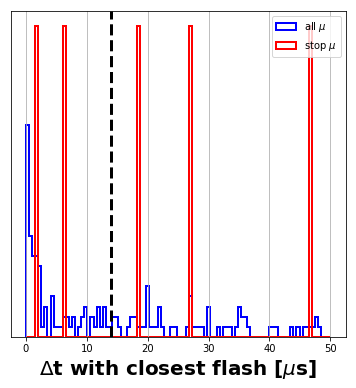

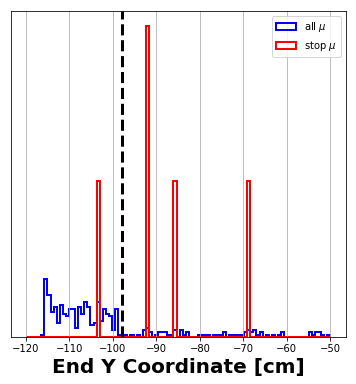

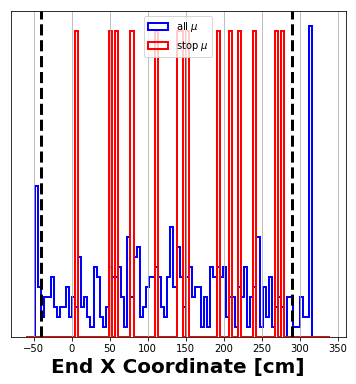

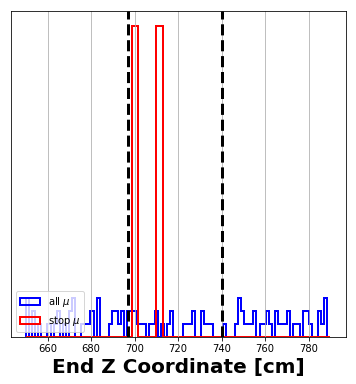

In [12]:
TMAX = 50

fig = plt.figure(figsize=(6,6))
plt.hist(df['_delta_t_closest_flash'].values    ,bins=np.linspace(0,TMAX,100),\
         histtype='step',lw=2,color='b',normed=True,label='all $\mu$')
plt.hist(dfstop['_delta_t_closest_flash'].values,bins=np.linspace(0,TMAX,100),\
         histtype='step',lw=2,color='r',normed=True,label='stop $\mu$')
plt.xlabel('$\Delta$t with closest flash [$\mu$s]',fontsize=20,fontweight='bold')
plt.grid()
plt.legend(loc=1)
plt.axvline(14,color='k',linestyle='--',lw=3)
plt.gca().axes.get_yaxis().set_ticks([])
plt.show()

fig = plt.figure(figsize=(6,6))
plt.hist(df['_trk_end_y'].values    ,bins=np.linspace(-120,-50,100),\
         histtype='step',lw=2,color='b',normed=True,label='all $\mu$')
plt.hist(dfstop['_trk_end_y'].values,bins=np.linspace(-120,-50,100),\
         histtype='step',lw=2,color='r',normed=True,label='stop $\mu$')
plt.xlabel('End Y Coordinate [cm]',fontsize=20,fontweight='bold')
plt.grid()
plt.legend(loc=1)
plt.axvline(-98,color='k',linestyle='--',lw=3)
plt.gca().axes.get_yaxis().set_ticks([])
plt.show()

fig = plt.figure(figsize=(6,6))
plt.hist(df['_trk_end_x'].values    ,bins=np.linspace(-60,340,100),\
         histtype='step',lw=2,color='b',normed=True,label='all $\mu$')
plt.hist(dfstop['_trk_end_x'].values,bins=np.linspace(-60,340,100),\
         histtype='step',lw=2,color='r',normed=True,label='stop $\mu$')
plt.xlabel('End X Coordinate [cm]',fontsize=20,fontweight='bold')
plt.grid()
plt.legend(loc=9)
plt.axvline(-40,color='k',linestyle='--',lw=3)
plt.axvline(290,color='k',linestyle='--',lw=3)
plt.gca().axes.get_yaxis().set_ticks([])
plt.show()

fig = plt.figure(figsize=(6,6))
plt.hist(df['_trk_end_z'].values    ,bins=np.linspace(650,790,100),\
         histtype='step',lw=2,color='b',normed=True,label='all $\mu$')
plt.hist(dfstop['_trk_end_z'].values,bins=np.linspace(650,790,50),\
         histtype='step',lw=2,color='r',normed=True,label='stop $\mu$')
plt.xlabel('End Z Coordinate [cm]',fontsize=20,fontweight='bold')
plt.grid()
plt.legend(loc=3)
plt.axvline(697,color='k',linestyle='--',lw=3)
plt.axvline(740,color='k',linestyle='--',lw=3)
plt.gca().axes.get_yaxis().set_ticks([])
plt.show()

In [14]:
print df.shape[0]

# study impact of cuts
cut_v = ['BA_000_050 != -1 and BA_050_100 != -1',\
         '_trk_end_y > -98',\
         #'_px < 0',\
         '_trk_end_z < 697 or _trk_end_z > 742',\
         '_trk_end_x > -40 and _trk_end_x < 290',\
         '_trk_end_z > 10 and _trk_end_z < 1020.',\
         '_delta_t_closest_flash > 14',\
         #'mip > 200 and mip < 350',\
         'BA_000_050 > 10 and BA_000_050 < 20',\
         #'BA_050_100 < 10',\
         #'miperr/mip < 0.1',\
         'mipfit > 1.5 and mipfit < 2.0',\
         ]

dfcuts = df
dfgood = df.query('_yz_true_reco_distance < 5.')

for cut in cut_v:
    dfcuts = dfcuts.query(cut)
    allmu  = dfcuts.shape[0]
    dfgood = dfgood.query(cut)
    stpmu  = dfgood.shape[0]
    eff    = stpmu/19000.
    print 'cut %40s : all = %05i ... stop = %05i ... purity = %.03f ... eff = %.02f'%\
    (cut,allmu,stpmu,100*float(stpmu)/float(allmu),eff)
    
    
stop_res_v = np.linspace(0,15,16)
purity_v = []
purity_e = []

for res in stop_res_v:
    
    dfgood = df.query('_dmin < %f'%res)

    for cut in cut_v:
        dfcuts = dfcuts.query(cut)
        dfgood = dfgood.query(cut)
        
    allmu = dfcuts.shape[0]
    stopmu = dfgood.shape[0]
    
    p = float(stopmu)/float(allmu)
    error = np.sqrt(p*(1-p)/float(allmu))
    
    purity_v.append(p)
    purity_e.append(error)

427
cut    BA_000_050 != -1 and BA_050_100 != -1 : all = 00427 ... stop = 00016 ... purity = 3.747 ... eff = 0.00
cut                         _trk_end_y > -98 : all = 00161 ... stop = 00015 ... purity = 9.317 ... eff = 0.00
cut     _trk_end_z < 697 or _trk_end_z > 742 : all = 00148 ... stop = 00012 ... purity = 8.108 ... eff = 0.00
cut    _trk_end_x > -40 and _trk_end_x < 290 : all = 00104 ... stop = 00012 ... purity = 11.538 ... eff = 0.00
cut   _trk_end_z > 10 and _trk_end_z < 1020. : all = 00084 ... stop = 00012 ... purity = 14.286 ... eff = 0.00
cut              _delta_t_closest_flash > 14 : all = 00010 ... stop = 00004 ... purity = 40.000 ... eff = 0.00


ZeroDivisionError: float division by zero

In [ ]:
fig = plt.figure(figsize=(6,6))
plt.errorbar(stop_res_v,purity_v,yerr=purity_e,fmt='bo',markersize=10,lw=3)
plt.grid()
plt.ylim([0.7,1.0])
plt.xlabel('Stopping Point Accuracy [cm]',fontsize=20,fontweight='bold')
plt.ylabel('purity [frac]',fontsize=20,fontweight='bold')
plt.title('Stop Muon Selection',fontsize=20,fontweight='bold')
plt.show()

In [ ]:
rr_cumulative_v   = []
dqdx_cumulative_v = []
dqdx_trunc_cumulative_v = []
pitch_cumulative_v = []
pz_cumulative_v = []
py_cumulative_v = []
px_cumulative_v = []

poly_0 = []
dmin_v = []

for idx, entry in dfcuts.iterrows():
    
    rr_v   = np.array(entry['_rr_v'])
    dqdx_v = np.array(entry['_dqdx_v'])
    dqdx_trunc_v = np.array(entry['_dqdx_trunc_v'])
    pz = entry['_pz']
    py = entry['_py']
    px = entry['_px']
    pitch = 0.3/np.abs(pz)
    
    
    for dqdx in dqdx_v:
        dqdx_cumulative_v.append(dqdx)
    for dqdx in dqdx_trunc_v:
        dqdx_trunc_cumulative_v.append(dqdx)
    for rr in rr_v:
        rr_cumulative_v.append(rr)
        pitch_cumulative_v.append(pitch)
        px_cumulative_v.append(px)
        py_cumulative_v.append(py)
        pz_cumulative_v.append(pz)

In [ ]:
fig = plt.figure(figsize=(12,6))
BINS = ( np.linspace(0,200,100), np.linspace(150,500,100) )
plt.hist2d(rr_cumulative_v,dqdx_cumulative_v,bins=BINS)
plt.xlabel('Residual Range [cm]',fontsize=20,fontweight='bold')
plt.ylabel('dQ/dx [ADC / cm]',fontsize=20,fontweight='bold')
plt.title('dQ/dx vs. RR for selected tracks [cosmic MC sample]',fontweight='bold',fontsize=18)
plt.grid()
plt.show()

In [ ]:
# save to picke file:
fout = open('stopmu_mcc83.csv','wb')

for i,rr in enumerate(rr_cumulative_v):
    px = px_cumulative_v[i]
    py = py_cumulative_v[i]
    pz = pz_cumulative_v[i]
    fout.write('%.02f \t %.02f \t %.02f \t %.02f \t %.02f \t %.02f \n'%\
               (rr,dqdx_cumulative_v[i],pitch_cumulative_v[i],px,py,pz))
    
fout.close()

In [ ]:
# VALIDATE RANGE vs. CALORIMETRY ENERGY

In [ ]:
# invert Recombination Modified Box Model to get dE/dx from dQ/dx

# argon density [g/cm^3]
rho = 1.396
# electric field [kV/cm]
efield = 0.273
# ionization energy [MeV/e-]
Wion = 23.6*(10**(-6))

fModBoxA = 0.93
fModBoxB = 0.562

def ModBoxInverse(dqdx):
    dedx = (np.exp(fModBoxB * Wion * dqdx ) - fModBoxA) / fModBoxB
    return dedx   

In [ ]:
from scipy.interpolate import spline

pdg_rr_v = []
pdg_dedx_v = []
pdg_ke_v = []
pdg_rr_fit_v = []
pdg_dedx_fit_v = []
pdg_ke_fit_v = []

fin = open('/home/david//Dropbox/Neutrinos/Varie/michelCalib/mutable.txt')
rho = 1.396

for line in fin:
    words = line.split()
    pdg_rr_v.append(   float(words[-1])/rho )
    pdg_dedx_v.append( float(words[2]) *rho )
    pdg_ke_v.append(   float(words[0])      )


pdg_rr_fit_v   = np.linspace(1,1000,10000)
pdg_dedx_fit_v = spline(pdg_rr_v,pdg_dedx_v,pdg_rr_fit_v)
pdg_ke_fit_v = spline(pdg_rr_v,pdg_ke_v,pdg_rr_fit_v)


# fiven a RR value, get the energy
def ERange(RR):
    for i in xrange(len(pdg_rr_fit_v)):
        if (RR <= pdg_rr_fit_v[i]):
            return pdg_ke_fit_v[i]              
    return -1

print ERange(76.14)

fig = plt.figure(figsize=(6,6))
plt.plot(pdg_ke_v,pdg_rr_v,'ro')
plt.grid()
plt.plot(pdg_ke_fit_v,pdg_rr_fit_v,'b--')
plt.xlim([180,220])
plt.ylim([70,80])
plt.xlabel('KE [MeV]')
plt.ylabel('Range [cm]')
#plt.xscale('log')
#plt.yscale('log')
plt.show()

In [ ]:
def Pitch(x):
    return 0.3/np.abs(x['_pz'])

dfcuts['pitch'] = dfcuts.apply(lambda x : Pitch(x),axis=1)

In [ ]:
def Energy(x,elecgain):
    energy = 0.
    dqdx_v = x['_dqdx_v']
    rr_v   = x['_rr_v']
    for i in xrange(1,len(dqdx_v)):
        dqdx = dqdx_v[i]
        drr  = np.abs(rr_v[i-1]-rr_v[i])
        dedx = ModBoxInverse(dqdx*elecgain)
        energy += drr * dedx
    energy += (np.abs(rr_v[0]-rr_v[1])) * ModBoxInverse(dqdx_v[0]*elecgain)
    return energy

dfcuts['energy'] = dfcuts.apply(lambda x : Energy(x,200.), axis=1)

In [ ]:
def EnergyfromRange(x):
    rrmax = np.max(x['_rr_v'])
    return ERange(rrmax)
dfcuts['erange'] = dfcuts.apply(lambda x : EnergyfromRange(x),axis=1)

In [ ]:
def gauss(x,mu,sigma,A):
    return A * (1./np.sqrt(np.pi*2*sigma*sigma)  * np.exp(-((x-mu)**2)/(2*sigma*sigma) ))

In [ ]:
NSKIP = 35

In [ ]:
fig = plt.figure(figsize=(6,6))
BINS = (np.linspace(200,800,50),np.linspace(200,800,50))
plt.hist2d(dfcuts['_energy_mc'].values-105.,dfcuts['energy'].values,bins=BINS)
plt.grid()
plt.ylabel('Calorimetry Energy [MeV]',fontsize=20,fontweight='bold')
plt.xlabel('Truth Energy [MeV]',fontsize=20,fontweight='bold')
plt.xlim([300,800])
plt.ylim([300,800])
plt.show()

dfratio = dfcuts.query('energy/erange > 0.5 and energy/erange < 1.5')
frac_v = dfratio['energy'].values/dfratio['erange'].values

vals,bine = np.histogram(frac_v,bins=np.linspace(0.5,1.5,100))
binc = 0.5*(bine[1:]+bine[:-1])
popt,popv = curve_fit(gauss,binc[NSKIP:-NSKIP],vals[NSKIP:-NSKIP],p0=[1.0,0.1,np.sum(vals)])
xvals = np.linspace(binc[NSKIP],binc[-NSKIP],1000)

fig = plt.figure(figsize=(6,6))
plt.plot(xvals,gauss(xvals,*popt),'r--',lw=3,label='$\mu$ = %.02f $\sigma$ = %.02f'%(popt[0],popt[1]))
plt.errorbar(binc,vals,yerr=np.sqrt(vals),fmt='bo',lw=2,markersize=8)
#plt.hist(frac_v,bins=np.linspace(0.7,1.3,50),histtype='step',lw=2)
plt.xlim([0.5,1.5])
plt.ylim([0,np.max(vals)*1.3])
plt.grid()
plt.legend()
plt.ylabel('Number of Tracks',fontsize=20,fontweight='bold')
plt.xlabel('Calorimetry Energy / Truth Energy',fontsize=20,fontweight='bold')
plt.show()

In [ ]:
fig = plt.figure(figsize=(6,6))
BINS = (np.linspace(200,800,50),np.linspace(200,800,50))
plt.hist2d(dfcuts['_energy_mc'].values-105.,dfcuts['erange'].values,bins=BINS)
plt.grid()
plt.ylabel('Range Energy [MeV]',fontsize=20,fontweight='bold')
plt.xlabel('Truth Energy [MeV]',fontsize=20,fontweight='bold')
plt.xlim([300,800])
plt.ylim([300,800])
plt.show()

fig = plt.figure(figsize=(6,6))
dfratio = dfcuts.query('erange/_energy_mc > 0 and erange/_energy_mc < 1.5')
frac_v = dfratio['erange'].values/(dfratio['_energy_mc'].values-105.)

vals,bine = np.histogram(frac_v,bins=np.linspace(0.5,1.5,100))
binc = 0.5*(bine[1:]+bine[:-1])
popt,popv = curve_fit(gauss,binc[NSKIP:-NSKIP],vals[NSKIP:-NSKIP],p0=[1.0,0.1,np.sum(vals)])
xvals = np.linspace(binc[NSKIP],binc[-NSKIP],1000)

fig = plt.figure(figsize=(6,6))
plt.plot(xvals,gauss(xvals,*popt),'r--',lw=3,label='$\mu$ = %.02f $\sigma$ = %.02f'%(popt[0],popt[1]))
plt.errorbar(binc,vals,yerr=np.sqrt(vals),fmt='bo',lw=2,markersize=8)
#plt.hist(frac_v,bins=np.linspace(0.7,1.3,50),histtype='step',lw=2)
plt.xlim([0.5,1.5])
plt.ylim([0,np.max(vals)*1.3])
plt.grid()
plt.legend()
plt.ylabel('Number of Tracks',fontsize=20,fontweight='bold')
plt.xlabel('Range Energy / Truth Energy',fontsize=20,fontweight='bold')
plt.show()

In [ ]:
fig = plt.figure(figsize=(6,6))
BINS = (np.linspace(200,800,50),np.linspace(200,800,50))
plt.hist2d(dfcuts['erange'].values,dfcuts['energy'].values,bins=BINS)
plt.grid()
plt.ylabel('Range Energy [MeV]',fontsize=20,fontweight='bold')
plt.xlabel('Calorimetry Energy [MeV]',fontsize=20,fontweight='bold')
plt.xlim([300,800])
plt.ylim([300,800])
plt.show()

fig = plt.figure(figsize=(6,6))
#dfratio = dfcuts.query('energy/_energy_mc > 0 and energy/_energy_mc < 1.5')
frac_v = dfcuts['energy'].values/dfcuts['erange'].values


vals,bine = np.histogram(frac_v,bins=np.linspace(0.5,1.5,100))
binc = 0.5*(bine[1:]+bine[:-1])
popt,popv = curve_fit(gauss,binc[NSKIP:-NSKIP],vals[NSKIP:-NSKIP],p0=[1.0,0.1,np.sum(vals)])
xvals = np.linspace(binc[NSKIP],binc[-NSKIP],1000)

fig = plt.figure(figsize=(6,6))
plt.plot(xvals,gauss(xvals,*popt),'r--',lw=3,label='$\mu$ = %.02f $\sigma$ = %.02f'%(popt[0],popt[1]))
plt.errorbar(binc,vals,yerr=np.sqrt(vals),fmt='bo',lw=2,markersize=8)
#plt.hist(frac_v,bins=np.linspace(0.7,1.3,50),histtype='step',lw=2)
plt.xlim([0.5,1.5])
plt.ylim([0,np.max(vals)*1.3])
plt.grid()
plt.legend()
plt.ylabel('Number of Tracks',fontsize=20,fontweight='bold')
plt.xlabel('Calorimetry Energy / Range Energy',fontsize=20,fontweight='bold')
plt.show()